In [2]:
#Importamos las librerias necesarias para llevar a cabo el proyecto.
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,KFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor


In [3]:
original = pd.read_csv('coches-de-segunda-mano-sample.csv')
df = original.copy()

In [4]:
df['price_financed'] = df['price_financed'].fillna(0)

In [5]:
df.drop_duplicates(inplace=True)    
df.dropna(inplace=True)


In [6]:
df.shape

(41245, 21)

In [7]:
df_train = df.iloc[:5000,:]
df_no_viewed_data = df.iloc[40000:,:]

In [8]:
columns_to_delete = ['url','company','doors','color', 'photos','is_professional', 'dealer', 'province', 'country', 'publish_date','insert_date']
df_train.drop(columns=columns_to_delete,inplace=True)
df_no_viewed_data.drop(columns=columns_to_delete,inplace=True)



C:\Users\guill\AppData\Local\Temp\ipykernel_5228\1137906194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=columns_to_delete,inplace=True)
C:\Users\guill\AppData\Local\Temp\ipykernel_5228\1137906194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_viewed_data.drop(columns=columns_to_delete,inplace=True)


In [9]:
df_train['year']=df_train['year'].astype(int)
df_train['power']=df_train['power'].astype(int)

C:\Users\guill\AppData\Local\Temp\ipykernel_5228\2908027367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['year']=df_train['year'].astype(int)
C:\Users\guill\AppData\Local\Temp\ipykernel_5228\2908027367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['power']=df_train['power'].astype(int)


In [10]:
numericas=['price','price_financed','kms','power']

# FUNCIÓN QUE DEVUELVE LOS NÚMEROS DE FILA EN LOS QUE LA VARIABLE EN CUESTIÓN ES OULIER
def outliers(var):
    q3=var.quantile(0.75)
    q1=var.quantile(0.25)
    riq=q3-q1
    sup=q3+1.5*(riq)
    inf=q1-1.5*(riq)
    outl=(var>sup) | (var<inf)
    return outl

for i in df_train.loc[:,numericas]:
    print("Cantidad de oultliers de la variable",i,":",outliers(df_train[i]).sum())
# Eliminar outliers
# Tu código
for i in df_train.loc[:,numericas]:
    df_train=df_train[~outliers(df_train[i])]
df_train.sample(5)

Cantidad de oultliers de la variable price : 255
Cantidad de oultliers de la variable price_financed : 143
Cantidad de oultliers de la variable kms : 62
Cantidad de oultliers de la variable power : 421


,make,model,version,price,price_financed,fuel,year,kms,power,shift
230,VOLKSWAGEN,Touran,VOLKSWAGEN Touran Edition 1.6 TDI BMT DSG 5p.,17299,15754.0,Diésel,2017,54478,115,Automático
4727,KIA,Carnival,KIA Carnival 2.9 CRDi LX 5p.,1390,0.0,Diésel,2004,225649,144,Manual
3002,RENAULT,Clio,RENAULT Clio Sport Tou. Limited 1.2 16v 55kW 7...,9450,8650.0,Gasolina,2017,26087,75,Manual
5541,OPEL,Grandland X,OPEL Grandland X 1.5 CDTi 120 Aniversario Auto...,28990,26990.0,Diésel,2020,5,130,Automático
5080,VOLKSWAGEN,T-Roc,VOLKSWAGEN TRoc Sport 2.0 TDI 110kW 150CV 4 Mo...,38518,36592.0,Diésel,2018,6785,150,Automático


In [11]:
# Tu código
# Creamos el objeto que realizará la transformación

#Instancio el OneHot
onehot=OneHotEncoder()

# Aplico el OneHot a la columna job y guardo el resultao en a
onehot.fit(df_train[["make","model",'fuel','shift','version','kms']])
a=onehot.transform(df_train[["make","model",'fuel','shift','version','kms']])

# Convierto el a en data frame y lo llamo encoded_df
encoded_df = pd.DataFrame(a.toarray(), columns=onehot.get_feature_names_out(["make","model",'fuel','shift','version','kms']))

# Reseteo el índice de los dos data frames antes de concatenarlos
df_train.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# concateno los dos data frames y los guardo machacando el df
df_train=pd.concat([df_train,encoded_df],axis=1)

# Elimino la columna Job original antigua, la categórica
df_train.drop(columns=["make","model",'fuel','shift','version','kms'],inplace=True)

# Muestro tamaño yu sample del data frame df transformado
print(df_train.shape)
df_train.sample(5)

(4325, 5872)


,price,price_financed,year,power,make_ABARTH,make_ALFA ROMEO,make_AUDI,make_BMW,make_CHEVROLET,make_CHRYSLER,...,kms_305000,kms_307000,kms_310000,kms_312000,kms_313000,kms_314000,kms_315000,kms_316000,kms_319234,kms_320000
3608,38600,34600.0,2016,204,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3584,1650,0.0,2007,100,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179,14400,12700.0,2016,95,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,15000,0.0,2004,150,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,21990,20490.0,2016,150,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X= df_train.drop(columns=["price"],inplace=False)
y = df_train["price"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [14]:
# Definir el modelo XGBoost Regresión
xgb_model = XGBRegressor(subsample= 0.5, n_estimators= 200, min_child_weight=0.5, max_depth= 5,learning_rate= 0.1)

# Definir el espacio de búsqueda
# param_dist = {
#     'n_estimators': [100, 150, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.5, 0.7, 0.9],
#     'min_child_weight': [0.1, 0.5, 1.0]
# }

# Realizar la búsqueda aleatoria
xgb_model.fit(X_train,y_train)
# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = xgb_model.predict(X_test)

# Calcular el error cuadrático medio (MSE) en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)

# Imprimir el MSE en el conjunto de prueba
print(f'MSE en el conjunto de prueba: {mse}')


MSE en el conjunto de prueba: 4039739.7241800795


In [15]:
numericas=['price','price_financed','kms','power']

# FUNCIÓN QUE DEVUELVE LOS NÚMEROS DE FILA EN LOS QUE LA VARIABLE EN CUESTIÓN ES OULIER
def outliers(var):
    q3=var.quantile(0.75)
    q1=var.quantile(0.25)
    riq=q3-q1
    sup=q3+1.5*(riq)
    inf=q1-1.5*(riq)
    outl=(var>sup) | (var<inf)
    return outl

for i in df_no_viewed_data.loc[:,numericas]:
    print("Cantidad de oultliers de la variable",i,":",outliers(df_no_viewed_data[i]).sum())
# Eliminar outliers
# Tu código
for i in df_no_viewed_data.loc[:,numericas]:
    df_no_viewed_data=df_no_viewed_data[~outliers(df_no_viewed_data[i])]
df_no_viewed_data.sample(5)

Cantidad de oultliers de la variable price : 59
Cantidad de oultliers de la variable price_financed : 25
Cantidad de oultliers de la variable kms : 15
Cantidad de oultliers de la variable power : 106


,make,model,version,price,price_financed,fuel,year,kms,power,shift
48694,SUZUKI,Swace,SUZUKI Swace 1.8 GLX Hybrid 5p.,23800,22400.0,Gasolina,2021.0,0,122.0,Automático
49894,VOLKSWAGEN,Tiguan,VOLKSWAGEN Tiguan RLine 2.0 TDI 150CV DSG BMT ...,24900,23900.0,Diésel,2016.0,89000,150.0,Automático
49771,BMW,X1,BMW X1 sDrive16d 5p.,14990,13990.0,Diésel,2015.0,124000,116.0,Automático
49632,MINI,Countryman,MINI Countryman Cooper SD ALL4 5p.,35900,35000.0,Diésel,2018.0,24000,190.0,Automático
48792,NISSAN,QASHQAI,NISSAN QASHQAI 1.6dCi TEKNA 4x2 XTRONIC Piel 5p.,15900,0.0,Diésel,2016.0,120000,130.0,Automático


In [16]:
# Tu código
# Creamos el objeto que realizará la transformación

#Instancio el OneHot
onehot=OneHotEncoder()

# Aplico el OneHot a la columna job y guardo el resultao en a
onehot.fit(df_no_viewed_data[["make","model",'fuel','shift','version','kms']])
a=onehot.transform(df_no_viewed_data[["make","model",'fuel','shift','version','kms']])

# Convierto el a en data frame y lo llamo encoded_df
encoded_df = pd.DataFrame(a.toarray(), columns=onehot.get_feature_names_out(["make","model",'fuel','shift','version','kms']))

# Reseteo el índice de los dos data frames antes de concatenarlos
df_no_viewed_data.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# concateno los dos data frames y los guardo machacando el df
df_no_viewed_data=pd.concat([df_no_viewed_data,encoded_df],axis=1)

# Elimino la columna Job original antigua, la categórica
df_no_viewed_data.drop(columns=["make","model",'fuel','shift','version','kms'],inplace=True)

# Muestro tamaño yu sample del data frame df transformado
print(df_no_viewed_data.shape)
df_no_viewed_data.sample(5)

(1075, 2029)


,price,price_financed,year,power,make_ABARTH,make_ALFA ROMEO,make_AUDI,make_BMW,make_CHEVROLET,make_CHRYSLER,...,kms_290878,kms_293000,kms_293527,kms_300000,kms_305000,kms_310000,kms_314000,kms_315000,kms_319000,kms_320000
958,34500,31000.0,2019.0,150.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552,11500,0.0,2012.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,8490,7990.0,2018.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,2500,0.0,2005.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,9999,9117.0,2018.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
import pandas as pd
from xgboost import XGBRegressor

# Supongamos que tienes tu modelo previamente entrenado en best_model

# Supongamos que df_no_viewed_data es tu DataFrame con nuevos datos
# Ajusta las características según las necesidades reales de tu modelo

# Asegúrate de que las columnas en los nuevos datos coincidan con las columnas utilizadas durante el entrenamiento
# Esto puede implicar agregar o quitar columnas según sea necesario
new_data_encoded = df_no_viewed_data.reindex(columns=X_train.columns, fill_value=0)

# Utiliza el modelo XGBoost previamente entrenado (best_model) para hacer predicciones en los nuevos datos
new_predictions = xgb_model.predict(new_data_encoded)

# Crea una nueva columna 'predicted_price' en el DataFrame original (df_no_viewed_data) con las predicciones
df_no_viewed_data['predicted_price'] = new_predictions

# Imprime el DataFrame con las predicciones
print(df_no_viewed_data)


      price  price_financed    year  power  make_ABARTH  make_ALFA ROMEO  \
0      6990          6990.0  2010.0  110.0          0.0              0.0   
1     11490          9490.0  2018.0   85.0          0.0              0.0   
2      8400          6900.0  2010.0  177.0          0.0              0.0   
3      2500             0.0  2006.0   92.0          0.0              0.0   
4      7800          7200.0  2011.0  105.0          0.0              1.0   
...     ...             ...     ...    ...          ...              ...   
1070  18590         16590.0  2019.0  115.0          0.0              0.0   
1071  18490         16490.0  2018.0  140.0          0.0              0.0   
1072  14500         13551.0  2015.0  150.0          0.0              0.0   
1073  11000          9000.0  2019.0   72.0          0.0              0.0   
1074   2790             0.0  2006.0   70.0          0.0              0.0   

      make_AUDI  make_BMW  make_CHEVROLET  make_CHRYSLER  ...  kms_293000  \
0         

In [19]:
df_no_viewed_data.sample(5)

,price,price_financed,year,power,make_ABARTH,make_ALFA ROMEO,make_AUDI,make_BMW,make_CHEVROLET,make_CHRYSLER,...,kms_293000,kms_293527,kms_300000,kms_305000,kms_310000,kms_314000,kms_315000,kms_319000,kms_320000,predicted_price
423,17800,16500.0,2017.0,110.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17687.068359
368,15780,14280.0,2021.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15892.624023
610,10050,8950.0,2019.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10168.985352
856,14000,0.0,2009.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6950.246582
149,5490,4790.0,2009.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5152.906250


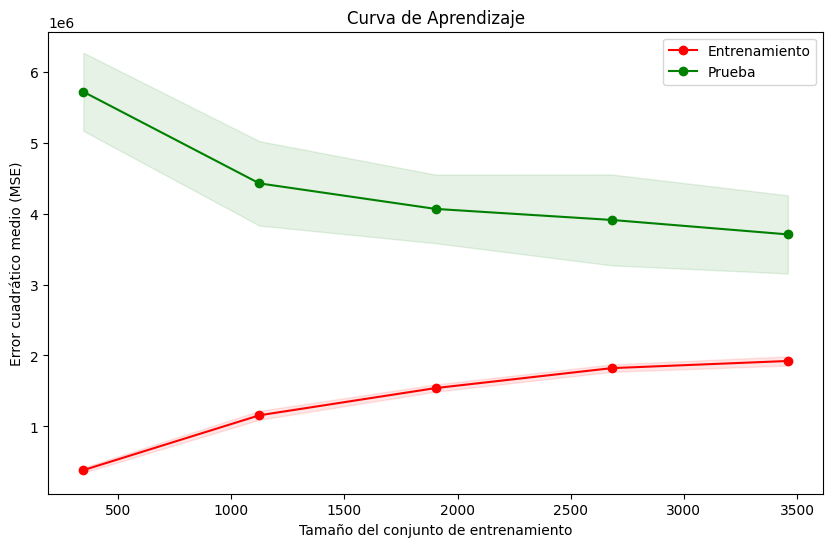

In [20]:
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calcula los promedios y las desviaciones estándar de los puntajes
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Crea el gráfico de curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Prueba")

plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Curva de Aprendizaje")
plt.legend(loc="best")
plt.show()

### PRUEBAS


In [22]:
n = 2035 - df['year']
def calcular_depreciacion_anual(year):
    if year <= 2019:  # Suponiendo que los datos están actualizados a 2024
        return 0.6  # Depreciación del 60% para los primeros 5 años
    else:
        return 0.1  # Depreciación del 10% a partir del quinto año

# Calcular la depreciación para cada fila del DataFrame
df['depreciacion_anual'] = df['year'].apply(calcular_depreciacion_anual)

# Calcular el precio depreciado para cada fila del DataFrame
df['precio_depreciado'] = df['price'] * (1 - df['depreciacion_anual'])**n

# Mostrar el DataFrame resultante
df

,url,company,make,model,version,price,price_financed,fuel,year,kms,...,color,photos,is_professional,dealer,province,country,publish_date,insert_date,depreciacion_anual,precio_depreciado
1,ff267ebb7e700246f47f84f3db660b4b,9881bcdd5a0ad4733037b3fb25e69c3a,CITROEN,C1,CITROEN C1 PureTech 60KW 82CV Feel 5p.,6200,0.0,Gasolina,2017.0,50071,...,Blanco,6,True,Autos Raymara,Tenerife,Spain,2021-01-02 11:25:40,2021-01-15 00:00:00,0.6,4.260608e-04
2,de4b02db28ea7786c622b969be10c7c7,9881bcdd5a0ad4733037b3fb25e69c3a,FORD,Transit Connect,FORD Transit Connect Van 1.5 TDCi 100cv Ambien...,7851,7024.0,Diésel,2016.0,103000,...,Blanco,10,True,Auto 96,Barcelona,Spain,2020-12-16 10:51:45,2021-01-15 00:00:00,0.6,2.158066e-04
3,0449972a4d07594acf92e9a7dd28b39c,9881bcdd5a0ad4733037b3fb25e69c3a,VOLKSWAGEN,Caravelle,VOLKSWAGEN Caravelle Largo 2.0 TDI 140 Comfort...,19426,0.0,Diésel,2014.0,120000,...,Blanco,9,True,Inniauto,Navarra,Spain,2020-11-25 11:09:14,2021-01-15 00:00:00,0.6,8.543645e-05
4,12c4fa49bd4fdf23f19ecf396d3f02ef,9881bcdd5a0ad4733037b3fb25e69c3a,FORD,Transit,FORD Transit 350 96kW L4 Ambiente Propulsion T...,22850,22800.0,Diésel,2017.0,107000,...,Blanco,4,True,"Autofleet España,s.l",Sevilla,Spain,2021-01-12 20:00:34,2021-01-15 00:00:00,0.6,1.570240e-03
5,f15e9a256de698bf0588753e7add0fdf,9881bcdd5a0ad4733037b3fb25e69c3a,PEUGEOT,3008,PEUGEOT 3008 Style 1.2 PureTech 130 SS 5p.,11490,10490.0,Gasolina,2016.0,78665,...,Blanco,32,True,Flexicar Rivas,Madrid,Spain,2021-01-08 17:03:33,2021-01-15 00:00:00,0.6,3.158347e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,730210734bfbe1d3df878d5df71246f2,9881bcdd5a0ad4733037b3fb25e69c3a,HYUNDAI,i30,HYUNDAI i30 1.4 TGDI Tecno Fastback DCT 5p.,18490,16490.0,Gasolina,2018.0,47000,...,Gris / Plata,26,True,Flexicar Málaga,Málaga,Spain,2020-11-24 19:59:52,2021-01-15 00:00:00,0.6,3.176558e-03
49996,732b04fb47dd9559dbdcd099c5af484e,9881bcdd5a0ad4733037b3fb25e69c3a,RENAULT,Laguna,RENAULT Laguna Coupe Limited 2.0 Energy dCi 15...,14500,13551.0,Diésel,2015.0,68750,...,KNG Gris Casiopea (metalizado),30,True,Ocasion Plus,Málaga,Spain,2021-01-13 17:02:41,2021-01-15 00:00:00,0.6,1.594292e-04
49997,c10afb53957fb8012707239bdfa66018,9881bcdd5a0ad4733037b3fb25e69c3a,PEUGEOT,108,PEUGEOT 108 TOP Allure VTi 52kW 72CV 5p.,11000,9000.0,Gasolina,2019.0,21422,...,Gris / Plata,17,True,Psa Retail Huelva,Huelva,Spain,2021-01-08 16:47:24,2021-01-15 00:00:00,0.6,4.724464e-03
49998,f74363a6688ba11b71b4d980a959b8d3,9881bcdd5a0ad4733037b3fb25e69c3a,AUDI,RS4,AUDI RS4 Avant 4.2 FSI 450cv quattro 5p.,47900,0.0,Gasolina,2013.0,47900,...,Gris / Plata (Antracita),20,True,Codigocar Lugo,Lugo,Spain,2021-01-13 16:22:53,2021-01-15 00:00:00,0.6,8.426657e-05


In [23]:
def calculo_precio_depreciado(precio,año_fabricacion,año_actual):
    precio_nuevo = precio * (0.9)**(año_actual - año_fabricacion)
    return precio_nuevo

In [24]:
df_no_viewed_data['precio_2035']=calculo_precio_depreciado(df_no_viewed_data['predicted_price'],2024,2035)

In [29]:
df_no_viewed_data[['year','price','predicted_price','precio_2035']].sample(5)

,year,price,predicted_price,precio_2035
654,2015.0,13500,13623.319336,4275.141602
200,2016.0,19900,18247.388672,5726.223633
869,2018.0,14950,16467.601562,5167.707520
690,2009.0,11500,12725.641602,3993.441162
980,2011.0,9490,9846.611328,3089.970947


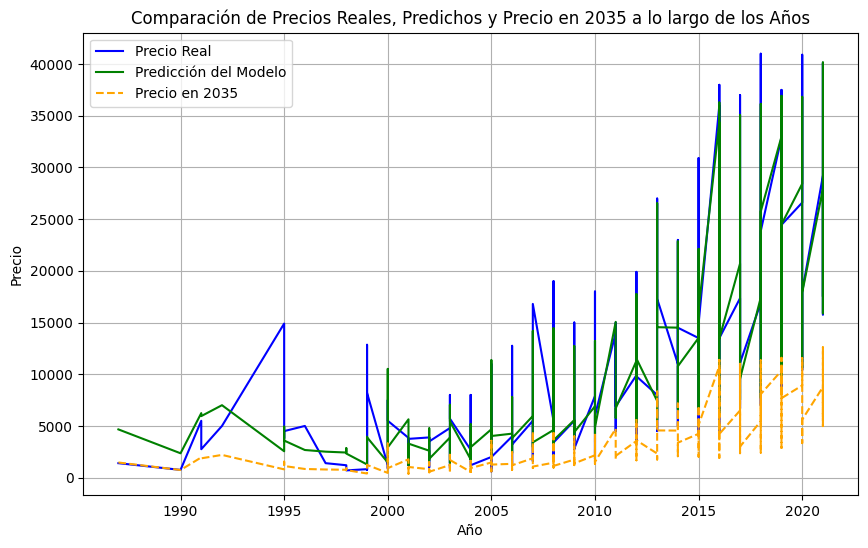

In [26]:
df_plot = df_no_viewed_data[['year', 'price', 'predicted_price', 'precio_2035']].sort_values(by='year')

# Colores llamativos y bien diferenciados
color_real = 'blue'
color_prediccion = 'green'
color_2035 = 'orange'

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_plot['year'], df_plot['price'], label='Precio Real', color=color_real)
plt.plot(df_plot['year'], df_plot['predicted_price'], label='Predicción del Modelo', color=color_prediccion)
plt.plot(df_plot['year'], df_plot['precio_2035'], label='Precio en 2035', linestyle='dashed', color=color_2035)

# Configurar el gráfico
plt.title('Comparación de Precios Reales, Predichos y Precio en 2035 a lo largo de los Años')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()